Task 3
Michael McAllister
101359469

This task tests your ability to apply Recommendation Engine concepts and techniques to a real-world Movie Recommender System.

Task: Build a Movie Recommender system with the following methods:
1. Popularity
2. Content Filter
3. Collaborative Filter
4. Matrix Factorization

Also, try the following libraries on the dataset:
5. Turicreate
6. Surprise

Dataset: MovieLens 20M 
Source: https://grouplens.org/datasets/movielens/20m/

Hints:
1. Read Movies.csv, Ratings.csv and Tags.csv. No need for genome-scores.csv, genome-tags.csv
2. Create content filtering method on metadata obtained from merging movies and tags
3. Metadata should be formed from joining all tag field for each movie_title.
4. Build a Tfidf Vectorizer model and TruncatedSVD for Content filter - Latent matrix 1 on this data
5. Create a Collab filter on User Movie matrix (formed from pivot table on ratings data)
6. Create a Latent matrix 2 on this data
7. Code hybrid model

Open a fresh notebook(.ipynb) and Name it as with the following convention:
If your name is Vejey Gandyer, your filename for ipynb should be "Vejey_Task3_Movie_Recommenders.ipynb".

Start creating cells and put the logic as and when required. 

Save the notebook and Submit the notebook (.ipynb).

In [1]:
#Importing necessary libraries, checked that GPU is running
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint
import torch
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

####################################### Content Recommender ##########################################

In [13]:
#importing movies and reviewed the structure
movies = pd.read_csv('movies.csv', encoding='latin-1')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
#Split genres categories to prepare categories to be used as features
movies.genres = movies.genres.str.split('|')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [15]:
# Separted year from movie title, to prepare the release year to be used as a feature
split_values = movies['title'].str.split("(", n = 1, expand = True)
# setting 'title' values to title part.
movies.title = split_values[0]
# creating 'release_year' column.
movies['release_year'] = split_values[1]
# Cleaning the release_year series.
movies['release_year'] = movies.release_year.str.replace(')','')

movies.head()

C:\Users\Mike\AppData\Local\Temp/ipykernel_10500/3305591941.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['release_year'] = movies.release_year.str.replace(')','')


,movieId,title,genres,release_year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [80]:
#imported tags and reviewed it's structure
tags = pd.read_csv('tags.csv').astype(str)
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [81]:
#Combined all tags per movieID
tag_agg = tags[['movieId','tag']].groupby(['movieId'])['tag'].transform(lambda x: ' '.join(x))
#Changed all values to lower case
tag_agg = tag_agg.str.lower()
#Removed all characters except alpha and single spaces
tag_agg = tag_agg.replace(('[^a-z A-Z]', ''), '',regex=True)  
tag_agg

0           mark waters naive mark waters freddie prinze jr
1         dark hero kevin costner adventure dystopia dys...
2         dark hero bittersweet cult film film noir ghos...
3         noir thriller neonoir noir thriller neonoir no...
4         dark hero dark dark hero adapted fromcomic alt...
                                ...                        
465559    fantasy grieving haphazard magic natalie portm...
465560    fantasy grieving haphazard magic natalie portm...
465561    fantasy grieving haphazard magic natalie portm...
465562    fantasy grieving haphazard magic natalie portm...
465563    bfi classic biographical view afi amazing cine...
Name: tag, Length: 465564, dtype: object

In [82]:
#Removed unnecessary and old tag column
tags_new = tags.drop(['userId','tag','timestamp'], axis=1)
#Append new composite values and made a tag column
tags_new['tag'] = tag_agg.values
#Removed duplicate movieIDs
tags_new.drop_duplicates(subset ="movieId", keep = 'first', inplace = True)
tags_new.head()

,movieId,tag
0,4141,mark waters naive mark waters freddie prinze jr
1,208,dark hero kevin costner adventure dystopia dys...
2,353,dark hero bittersweet cult film film noir ghos...
3,521,noir thriller neonoir noir thriller neonoir no...
4,592,dark hero dark dark hero adapted fromcomic alt...


In [83]:
#Converted movie_id in tags and movie database to numeric to make sure I can combine based on that column
movies["movieId"] = pd.to_numeric(movies["movieId"])
tags_new["movieId"] = pd.to_numeric(tags_new["movieId"])

#Created a new dataframe with merged values from movites and tags, left join on movieId
soup_prep = pd.merge(left=movies, right=tags_new, how='left', left_on='movieId', right_on='movieId')
soup_prep.head()

,movieId,title,genres,release_year,tag
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,watched computer animation disney animated fea...
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,time travel adapted frombook board game childh...
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,old people that is actually funny sequel fever...
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II,[Comedy],1995,diane keaton family sequel steve martin weddin...


In [84]:
#Converted data types back to strings before combining values
soup_prep['release_year'] = soup_prep['release_year'].astype(str)
soup_prep['tag'] = soup_prep['tag'].astype(str)

#Created a function to combine all relevant metadata columnscolumns
def create_soup(x):
    return ' '.join(x['genres']) + ' ' + x['release_year'] + ' ' + x['tag']

#Applied function to create one soup data column, dropped unnecessary columns
soup_prep['soup'] = soup_prep.apply(create_soup, axis=1)
soup_prep = soup_prep.drop(["genres", 'release_year', 'tag'], axis=1)

soup_prep.head()

,movieId,title,soup
0,1,Toy Story,Adventure Animation Children Comedy Fantasy 19...
1,2,Jumanji,Adventure Children Fantasy 1995 time travel ad...
2,3,Grumpier Old Men,Comedy Romance 1995 old people that is actuall...
3,4,Waiting to Exhale,Comedy Drama Romance 1995 chick flick revenge ...
4,5,Father of the Bride Part II,Comedy 1995 diane keaton family sequel steve m...


In [85]:
# created tfidf vectorizer function, including removing stop words 
tfidf = TfidfVectorizer(analyzer = 'word',stop_words = 'english')
#Filled no values
soup_prep['soup'] = soup_prep['soup'].fillna('')
#Created tfidf matrix
tfidf_matrix = tfidf.fit_transform(soup_prep['soup'])
tfidf_matrix.shape

(27278, 31862)

In [86]:
#created a vector of movie titles from the original movie index, to be used later when creating dataframes 
index_of_movies = pd.Series(soup_prep.index, index=soup_prep['title']).drop_duplicates()
len(index_of_movies)

27278

In [87]:
#Created the tfidf_df dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=soup_prep['title'].tolist())
print(tfidf_df.shape)

(27278, 31862)


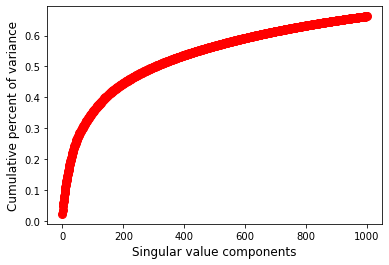

In [25]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [88]:
#Created latent_matrix_1_df with SVD reducing features to 1000
latent_matrix = svd.fit_transform(tfidf_df)
n = 1000
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=soup_prep['title'].tolist())
latent_matrix_1_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story,0.042639,-0.011495,-0.051853,0.063088,-0.062341,0.150068,-0.026692,-0.034751,0.062876,0.005894,...,-0.050989,0.082132,0.008842,-0.020440,0.034321,-0.054830,0.004083,0.044146,0.035579,0.040718
Jumanji,0.022113,0.019830,-0.022566,0.036183,-0.021904,0.086443,-0.034060,0.002308,0.017331,-0.003082,...,0.058541,0.090219,0.043777,0.070112,-0.065969,-0.050801,0.046440,0.046029,-0.017315,-0.077253
Grumpier Old Men,0.036744,-0.014810,-0.070540,0.036160,-0.007290,0.009004,0.019729,0.022227,-0.013039,-0.007573,...,-0.005636,-0.009744,-0.006965,0.017474,-0.025520,0.039902,-0.044073,-0.010904,-0.011502,0.023738
Waiting to Exhale,0.088662,-0.013447,-0.129281,0.012152,0.036392,0.008849,-0.007482,0.058940,-0.045321,-0.014475,...,0.011150,0.035601,0.070270,0.025355,-0.021980,0.001522,-0.053604,-0.062496,-0.018366,-0.095538
Father of the Bride Part II,0.038567,-0.010889,-0.070523,0.056817,-0.019555,0.026093,0.030570,0.005608,0.006875,-0.008504,...,0.255093,-0.074703,0.073141,0.083474,-0.079214,0.091807,0.054328,-0.040934,0.019890,0.047096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kein Bund fÃ¼r's Leben,0.482583,-0.191001,-0.131580,0.089133,-0.140357,-0.087467,0.103213,-0.070330,0.019396,-0.003058,...,-0.002940,0.002563,0.002583,-0.000400,-0.000756,-0.001475,0.001630,-0.003133,-0.001014,0.003017
"Feuer, Eis & Dosenbier",0.448334,-0.174181,-0.136093,0.062930,-0.156923,-0.050978,0.119185,-0.085790,0.061213,0.005703,...,-0.001996,0.002788,0.002081,-0.000134,0.000689,0.000555,0.000465,0.000575,-0.001035,-0.002040
The Pirates,0.026801,0.004378,-0.001226,0.009023,-0.011691,0.066334,-0.009694,-0.010333,0.008060,0.007673,...,-0.009989,-0.005638,-0.002103,0.006476,-0.002326,-0.001647,0.000541,0.002106,-0.015709,0.001362
Rentun Ruusu,0.223410,-0.079566,0.088346,-0.090410,-0.069070,-0.090806,-0.075184,-0.142061,0.101360,0.066719,...,-0.001418,0.001363,-0.001503,0.001123,-0.000495,0.001426,-0.000688,-0.001750,-0.000056,0.000532


########################## Ratings #########################################################################

In [7]:
from scipy.sparse import csr_matrix

In [8]:
#imported ratings
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


###################
Attempting 'user_movies_data = ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)'
caused an error, the ratings file is too large.  Instead I will use a subset of the ratings file
###################

In [9]:
ratings.drop_duplicates
ratings.shape

(20000263, 4)

In [10]:
#Created a subset of movie ratings that my computer is able to handle, sorted values based on the most recent ratings based on
#the timestamp, and took the most recent ratings
time_stamps = pd.DataFrame(ratings["timestamp"].value_counts()) 
ratings.sort_values(by=['timestamp'])
rat_subset = ratings[ratings["timestamp"] > 1210000000]
rat_subset.shape

(5576640, 4)

In [69]:
user_movies_data = rat_subset.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
user_movies_data

userId,11,14,18,25,31,36,42,43,47,49,...,138470,138471,138472,138473,138476,138479,138485,138489,138491,138493
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.5,4.5,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4.5,0.0,4.5,0.0,0.0,0.0,0.0,2.0,3.5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
#Added titles from the movies database to the ratings subset dataframe
user_movies_data['title'] = rat_subset['movieId'].map(soup_prep.set_index('movieId')['title'])
user_movies_data
#created a dataframe of just movieIds and titles, dropped duplicates to get a list of just 26599 rows to make pivot table
#rat_index = rat_subset[['movieId', 'title']].drop_duplicates()
#extracted title list to map indexes for hidden dataframe
#index_of_ratings = rat_index['title']
#rat_index.shape

userId,11,14,18,25,31,36,42,43,47,49,...,138471,138472,138473,138476,138479,138485,138489,138491,138493,title
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.5,4.5,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,...,4.5,0.0,4.5,0.0,0.0,0.0,0.0,2.0,3.5,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Primer
131256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Control Room
131258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Yes Men, The"


In [46]:
#decomonposed using SVD pivot table to 200 columns
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(user_movies_data)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=index_of_ratings)

In [47]:
latent_matrix_2_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,290.537596,50.359564,85.977510,6.405416,85.299107,7.360457,-2.583381,-41.046221,14.412383,-24.612840,...,-16.130880,7.440996,-10.621347,-1.978413,0.090168,-8.312111,2.596860,5.279611,1.942036,3.851166
GoldenEye,128.689736,-16.342421,54.442894,-37.480471,10.160717,-22.083051,-15.765723,-14.484618,-15.444626,-18.010566,...,-1.864096,9.483932,5.213627,0.702485,-6.320506,-0.833829,-0.902290,10.305460,-2.972560,0.007054
Ace Ventura: When Nature Calls,24.221181,-8.342616,5.115716,-22.963081,-1.671072,-2.767916,6.971657,3.564892,8.396957,-2.592895,...,1.617622,1.242614,-0.602816,-0.539674,1.100694,-0.230156,-0.456467,-0.187782,3.191929,1.116343
Twelve Monkeys,1.959242,-1.844691,0.079724,-2.323163,0.804960,-0.652798,1.145154,1.970370,0.545277,-1.311803,...,-0.130143,0.377898,0.560525,-0.137431,-0.050880,-0.094369,-0.006053,0.041359,-0.133859,-0.868736
Clueless,25.571764,-8.598391,8.280825,-18.540517,7.301837,-6.095705,9.193695,6.963091,5.144352,-6.934946,...,2.165046,4.125587,1.506742,-1.995133,-1.235026,-0.505910,3.437374,-0.207404,4.792580,1.962899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Gentleman from Epsom,0.067235,-0.098043,0.044640,0.027402,0.013526,-0.007433,-0.010227,0.068974,-0.026338,-0.075102,...,-0.033088,-0.025704,0.049601,-0.019895,0.012580,-0.050296,-0.070381,0.102266,0.022520,0.004793
The Great Spy Chase,0.067235,-0.098043,0.044640,0.027402,0.013526,-0.007433,-0.010227,0.068974,-0.026338,-0.075102,...,-0.033088,-0.025704,0.049601,-0.019895,0.012580,-0.050296,-0.070381,0.102266,0.022520,0.004793
Taxi for Tobruk,0.047112,-0.054789,-0.001410,-0.000381,-0.069682,-0.008220,-0.017566,0.015134,0.006918,-0.031678,...,0.035602,-0.004586,0.001649,0.034315,-0.000116,0.017317,0.048073,0.017560,-0.010872,0.055311


In [93]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.iloc[1]).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.iloc[1]).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
# dictDf = {'collaborative': score_2} 
similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
title,,,
Jingle All the Way,0.647900,0.117917,0.382909
Fat Man and Little Boy,0.639773,-0.003512,0.318130
Save the Date,0.637359,0.165113,0.401236
"Ambushers, The",0.635489,0.339262,0.487375
"Perfect Getaway, A",0.635180,0.142451,0.388815
Uuno in Spain,0.630145,0.036262,0.333204
"Golden Child, The",0.621127,0.100078,0.360602
Terminal USA,0.614811,-0.004347,0.305232
The Diary of Anne Frank,0.614055,0.013020,0.313538


In [94]:
similar.sort_values('collaborative', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
title,,,
Election,0.030783,0.905067,0.467925
Driving Miss Daisy,-0.036565,0.903614,0.433525
"Return of Jafar, The",0.361871,0.902989,0.632430
"Fish Called Wanda, A",-0.035305,0.890072,0.427384
Bride & Prejudice,0.013583,0.878679,0.446131
Charlie and the Chocolate Factory,0.048382,0.843298,0.445840
Push,0.010002,0.839749,0.424876
Secretariat,-0.036303,0.826053,0.394875
"Wedding Singer, The",0.007107,0.822438,0.414773


In [95]:
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
title,,,
"Return of Jafar, The",0.361871,0.902989,0.632430
X-Men Origins: Wolverine,0.565936,0.578411,0.572173
"Fourth Kind, The",0.356059,0.677035,0.516547
Highlander III: The Sorcerer,0.217255,0.796189,0.506722
Scream,0.555524,0.448705,0.502115
Super Mario Bros.,0.381357,0.615103,0.498230
"Ambushers, The",0.635489,0.339262,0.487375
Godzilla 2000,0.153540,0.791350,0.472445
Grey Gardens,0.578279,0.366423,0.472351


In [98]:
def recommend_similar_movies(index):
    # take the latent vectors for a selected movie from both content 
    # and collaborative matrixes
    a_1 = np.array(latent_matrix_1_df.iloc[index]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.iloc[index]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # an average measure of both content and collaborative 
    hybrid = ((score_1 + score_2)/2.0)

    # form a data frame of similar movies 
    dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

    #sort it on the basis of either: content, collaborative or hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    print(similar[1:].head(11))

In [99]:
recommend_similar_movies(1)

                                content  collaborative    hybrid
title                                                           
Return of Jafar, The           0.361871       0.902989  0.632430
X-Men Origins: Wolverine       0.565936       0.578411  0.572173
Fourth Kind, The               0.356059       0.677035  0.516547
Highlander III: The Sorcerer   0.217255       0.796189  0.506722
Scream                         0.555524       0.448705  0.502115
Super Mario Bros.              0.381357       0.615103  0.498230
Ambushers, The                 0.635489       0.339262  0.487375
Godzilla 2000                  0.153540       0.791350  0.472445
Grey Gardens                   0.578279       0.366423  0.472351
Murder!                        0.561552       0.381576  0.471564
Election                       0.030783       0.905067  0.467925


########################### Turicreate ###################################

In [104]:
! pip install turicrate

ERROR: Could not find a version that satisfies the requirement turicrate (from versions: none)
ERROR: No matching distribution found for turicrate


In [105]:
#Turicreate isn't available on windows, to install I would be required to install a Windows Subsystem for Linux (WSL)

############################## Matrix Factorization Recommender ########################

In [1]:
class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [10]:
#Creating a subset of the rat_subset table to limit how long the model will take
rat_subset = ratings[ratings["timestamp"] > 1410000000]
rat_subset.shape

(509844, 4)

In [11]:
R= np.array(rat_subset.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0))

In [ ]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 20 ; error = 615.7936


In [ ]:
###############################  Surprise #######################################################

In [4]:
!pip install surprise

  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp39-cp39-win_amd64.whl size=732191 sha256=6b12da4bf181bd02cae3d5ed1fe9eb04f97e9a3a5a916ad435e5199a9bf7bbf4
  Stored in directory: c:\users\mike\appdata\local\pip\cache\wheels\6b\10\c9\7f607c8cb522ef378844f41e63b30d7181a6495d2c1ae514e9
Successfully built scikit-surprise


In [5]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [11]:
rat_subset

,userId,movieId,rating,timestamp
960,11,1,4.5,1230858821
961,11,10,2.5,1230858959
962,11,19,3.5,1230783704
963,11,32,5.0,1230783095
964,11,39,4.5,1230859032
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


In [16]:
movies

,movieId,title,genres,release_year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
27273,131254,Kein Bund fÃ¼r's Leben,[Comedy],2007
27274,131256,"Feuer, Eis & Dosenbier",[Comedy],2002
27275,131258,The Pirates,[Adventure],2014
27276,131260,Rentun Ruusu,[(no genres listed)],2001


In [17]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [18]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rat_subset[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.7684


0.7683734093396961

In [23]:
def pred_user_rating(ui):
    if ui in ratings.userId.unique():
        ui_list = ratings[ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [24]:
userId = 1
pred_user_rating(userId)

,ratings
movies,
Shadows of Our Forgotten Ancestors,4.384286
"Saragossa Manuscript, The",4.340359
It's Such a Beautiful Day,4.340216
Heimat - A Chronicle of Germany,4.336986
Death on the Staircase,4.321441
Frozen Planet,4.304642
Life Is Beautiful,4.287823
"Lives of Others, The",4.276868
"Bonheur, Le",4.265573


In [26]:
pred_user_rating(6)

,ratings
movies,
"Shawshank Redemption, The",4.406039
Shadows of Our Forgotten Ancestors,4.384286
"Saragossa Manuscript, The",4.340359
It's Such a Beautiful Day,4.340216
Heimat - A Chronicle of Germany,4.336986
Death on the Staircase,4.321441
Frozen Planet,4.304642
Life Is Beautiful,4.287823
"Lives of Others, The",4.276868
